In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
%matplotlib inline
sns.set_style('dark')

import keras
import tensorflow
from keras.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline

### Utility functions



In [80]:
#calculate mae
def sam_mape(actual, predicted):
    
    #calcualtes the mean absolute percent error 
        
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [115]:
#time series split 
    
def split_sequences(sequences, n_steps, extra_lag=False, long_lag_step=7, max_step=30, idx=0):
    
    
    #if not adding extra lag features adjust max_step and n_steps to aling
    if not extra_lag:
        max_step=n_steps
        n_steps+=1
        
    
    X, y = list(), list()
    for i in range(len(sequences)):
        
        # find the end of this pattern
        
        end_ix = i + max_step
        
        #list with the indexes to include in each sample
        slices = [x for x in range(end_ix-1,end_ix-n_steps, -1)] + [y for y in range(end_ix-n_steps, i, -long_lag_step)]
        
        #reverse indexes
        slices = list(reversed(slices))
        
        # check if beyond the dataset
        if end_ix > len(sequences)-1:
            break


        # obtain input and output parts 
        seq_x = sequences[slices, :]
        seq_y = sequences[end_ix, :]

        X.append(seq_x)
        y.append(seq_y)
        
    X = np.array(X)
    y = np.array(y)
    
    #obtain the first element (the demand)
    y = y[:,idx]
    
    return X, y

In [117]:
#time series feature extraction for the input to LSTM
def lstm_data(scaler=None, start='2016-01-01', stop='2016-01-05', n_lags=7, extra_lag=False, long_lag_step=7, max_lookback=30): 
    #load in the prepared dataset
    all_data = pd.read_csv('./data/clean_data_ondemand_pca.csv', parse_dates=True, index_col=0)

    #select data time slice
    data = all_data[start: stop].copy()
    
    #reshape the energy load columns to prepare for minmax scaling
    energy = data['Ontario_Demand'].values.reshape(-1,1)
    
    #minmax scale the energy column
    if scaler==None:
        scaler = MinMaxScaler().fit(energy)
        
    data_normd = scaler.transform(energy)
    
    #reset the energy column to the actual loads
    data['Ontario_Demand'] = data_normd.copy()
    
    #create single columns with time features
    data.loc[:,'year'] = data.index.year
    data.loc[:,'month'] = data.index.month
    data.loc[:,'day'] = data.index.day
    data.loc[:,'hours'] = data.index.hour
    
    hours_tup = [] 

    #for each unique hour isolate the features and dates
    for h in data.hours.unique():
        
        #boolean mask for each hour of the day
        hour = data[data.hours==h].copy()
        #drop extra columns
        hour.drop(['year', 'month', 'day', 'hours'], axis=1, inplace=True)
        #reshape 2D into a 3D matrix for stacking
        hour = np.reshape(hour.values, (hour.shape[0], hour.shape[1], 1))
        #append each 3d slice into list
        hours_tup.append(hour)
    
    
    tup = tuple(hours_tup)
    
    #stack all the 3D arrays into 1 single 3D array
    hours_stacked = np.dstack(tup)
    
    #make samples from hours stacked
    X_4d, y = split_sequences(hours_stacked, 
                           n_lags, 
                           extra_lag=extra_lag, 
                           long_lag_step=long_lag_step, 
                           max_step=max_lookback, 
                           idx=0 
                           )
    
    
    
    X = []

    #flatten the multidimensional arrays into a single array of lags & features, hours
    for j in range(len(X_4d)):
        #reshape the inner dimensions
        n = X_4d[j].reshape(-1, hours_stacked.shape[-1])
        X.append(n)
    
    X = np.array(X)
    
    
    return X, y, scaler

In [119]:
X_, y_, scaler_energy = lstm_data(start='2016-01-01', stop='2016-01-17', n_lags=7)
X_.shape, y_.shape

((10, 77, 24), (10, 24))

### Defining LSTM model and related function.

In [122]:
#define an LSTM model

def lstm_in_out(n_features, n_hours, cells=50, learning_rate=1e-3):
    
    #define the model
    
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(cells, activation='relu', return_sequences=True, input_shape=(n_features, n_hours)))
    model.add(keras.layers.LSTM(int(cells/2), activation='relu'))
    model.add(keras.layers.Dense(n_hours))
    
    #define the learning rate
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    #compile model
    model.compile(optimizer=optimizer, loss='mae')
    
    return model

In [124]:
#Obtain the feature sets for X and y and set the train period 
#Use the data from 2016 to 2019 for training 
n_hours = 24
lr = 1e-3
verbose = 1
epochs = 50
max_lookback = 30
extra_lag=True
#prepare the data for training
X_m, y_m, scaler_m = lstm_data(start='2016-01-01', 
                                                                    stop='2019-12-31', 
                                                                    n_lags=7, 
                                                                    extra_lag=True,
                                                                    long_lag_step=7, 
                                                                    max_lookback=max_lookback)
n_features = X_m.shape[1]
lstm_m = lstm_in_out(n_features, n_hours, learning_rate=lr)



/Users/mmousavi/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [126]:
y_m.shape

(1431, 24)

In [128]:
X_m.shape

(1431, 110, 24)

In [132]:
#train the model for 4 years
lstm_m.fit(X_m, y_m, epochs=epochs, verbose=verbose, shuffle=False)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3366
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1563
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1181
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1099
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1067
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1044
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1032
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1025
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1020
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1008
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0999
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0988
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0978
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1029
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1022
Epoc

In [134]:
#prepare test data for year 2020
X_m_test, y_m_test, scaler_m = lstm_data(scaler_m, start='2020-01-01', 
                                                                    stop='2020-12-31', 
                                                                    n_lags=7, 
                                                                    extra_lag=True,
                                                                    long_lag_step=7, 
                                                                    max_lookback=max_lookback)

In [136]:
X_m_test.shape

(336, 110, 24)

In [138]:
y_m_test.shape

(336, 24)

In [140]:
#predict for the test set
predict = lstm_m.predict(X_m_test, verbose=verbose)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [152]:
# obtain the true values for predictions and actuals
predictions = []
actuals = []


#inverse transform values
prediction = scaler_m.inverse_transform(predict)
actual = scaler_m.inverse_transform(y_m_test.copy())

#save the results in a list
predictions.append(prediction)
actuals.append(actual)


#convert results to numpy array for easy manipulation
predictions = np.array(predictions)
actuals = np.array(actuals)

print(predictions.shape)
print(actuals.shape)
 


(1, 336, 24)
(1, 336, 24)


### Obtain MAPE for 3 days in July and 3 days in August 2020 for which MAPE is less than 4%, then draw the graphs for the predicted and actual 24 hours demands

In [182]:
days=[]
for i in range(183, 244):
    mape = sam_mape(actuals[0][i], predictions[0][i])
    if mape<4:
        days.append(i)

In [257]:
mape_1 = sam_mape(actuals[0][days[0]], predictions[0][days[0]])
print(round(mape_1, 1))
# Wednesday
# July 1, 2020

3.7


In [259]:
mape_2 = sam_mape(actuals[0][days[4]], predictions[0][days[4]])
print(round(mape_2, 1))
# Friday
# July 17, 2020

2.5


In [261]:
mape_3 = sam_mape(actuals[0][days[7]], predictions[0][days[7]])
print(round(mape_3, 1))
# Thursday
# July 30, 2020

3.6


In [263]:
mape_4 = sam_mape(actuals[0][days[11]], predictions[0][days[11]])
print(round(mape_4,1))
# Sunday
# August 9, 2020

3.0


In [265]:
mape_5 = sam_mape(actuals[0][days[15]], predictions[0][days[15]])
print(round(mape_5, 1))
# Saturday
# August 15, 2020

2.3


In [267]:
mape_6 = sam_mape(actuals[0][days[20]], predictions[0][days[20]])
print(round(mape_6, 1))
# Saturday
# August 22, 2020

2.2


In [253]:
def plot_all(actuals, predictions):

    
    plots = 2
    
    days = [183, 199, 212, 222, 228, 235]
    day_name_mape = {228:f"Saturday August 15, 2020, MAPE={round(mape_5,1)}%",
                     222:f" Sunday August 9, 2020, MAPE={round(mape_4, 1)}%",
                     235:f"Saturday August 22, 2020, MAPE={round(mape_6,1)}%",
                    183:f"Wednesday July 1, 2020, MAPE={round(mape_1,1)}%",
                     199:f" Friday July 17, 2020, MAPE={round(mape_2, 1)}%",
                     212:f"Thursday July 30, 2020, MAPE={round(mape_3,1)}%"}
    #set figure
    fig, axs = plt.subplots(plots,3, figsize=(6,4), squeeze=False)

    #loop through plots then loop through the days
    for i, axe in zip(range(plots), axs):
        for day, ax in zip(days, axe):
            
            #plot the predictions
            ax.plot(predictions[0][day], label='predicted')
            #plot actual values
            ax.plot(actuals[0][day], label='actual')
            ax.tick_params(axis='y', labelsize=6)
            ax.set_title('{}'.format(day_name_mape[day]),fontsize=6)
        days = days[3:]  
    #position the legend in the top left position of the top left chart.
    axs[0][0].legend(loc=2, fontsize=6)
    plt.subplots_adjust(hspace=0.3)

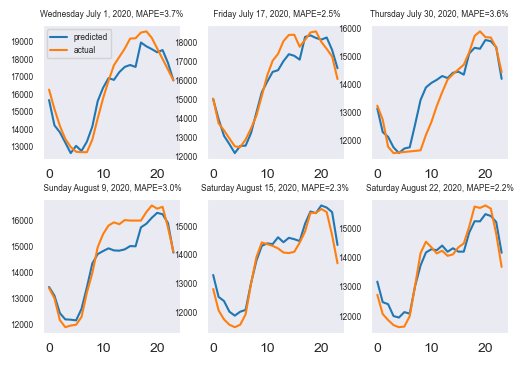

In [255]:
plot_all(actuals, predictions)